#### Imports and initialization

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set random seed for reproducibility
np.random.seed(42)

#### Step 1: Data loading and examination

In [23]:
df = pd.read_csv('BankChurners.csv')
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                     

In [24]:
print(df.head())

   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1       

In [25]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category 

In [26]:
print("\nSummary statistics for numerical columns:")
print(df.describe())


Summary statistics for numerical columns:
          CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
count  1.012700e+04  10127.000000     10127.000000    10127.000000   
mean   7.391776e+08     46.325960         2.346203       35.928409   
std    3.690378e+07      8.016814         1.298908        7.986416   
min    7.080821e+08     26.000000         0.000000       13.000000   
25%    7.130368e+08     41.000000         1.000000       31.000000   
50%    7.179264e+08     46.000000         2.000000       36.000000   
75%    7.731435e+08     52.000000         3.000000       40.000000   
max    8.283431e+08     73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000

In [27]:
print("\nDistribution of Attrition_Flag (target variable):")
print(df['Attrition_Flag'].value_counts())


Distribution of Attrition_Flag (target variable):
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64


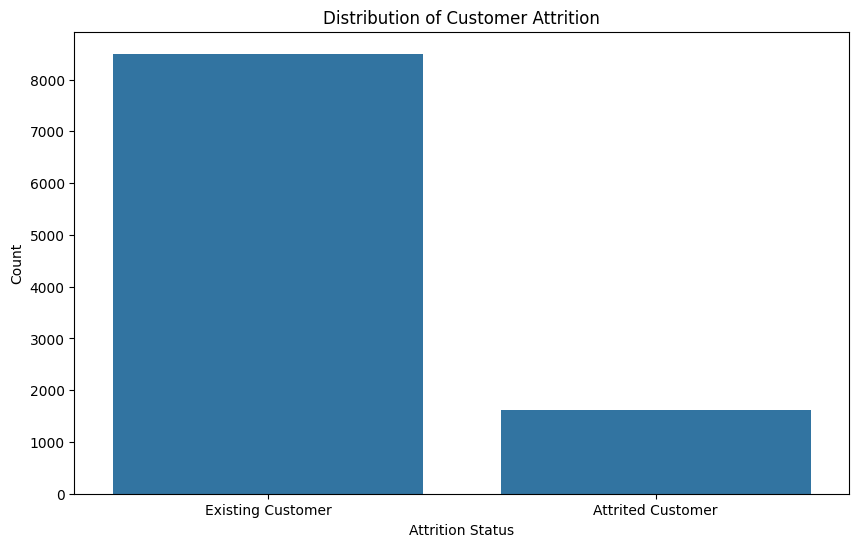

In [28]:
# Visualize the distribution of target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='Attrition_Flag', data=df)
plt.title('Distribution of Customer Attrition')
plt.xlabel('Attrition Status')
plt.ylabel('Count')
plt.show()

#### Step 2: Data preprocessing

In [29]:
# Drop the client number column as it's just an identifier
df = df.drop('CLIENTNUM', axis=1)

# Drop the Naive Bayes classifier columns as they seem to be from a previous analysis
df = df.drop([col for col in df.columns if col.startswith('Naive_Bayes_Classifier')], axis=1)

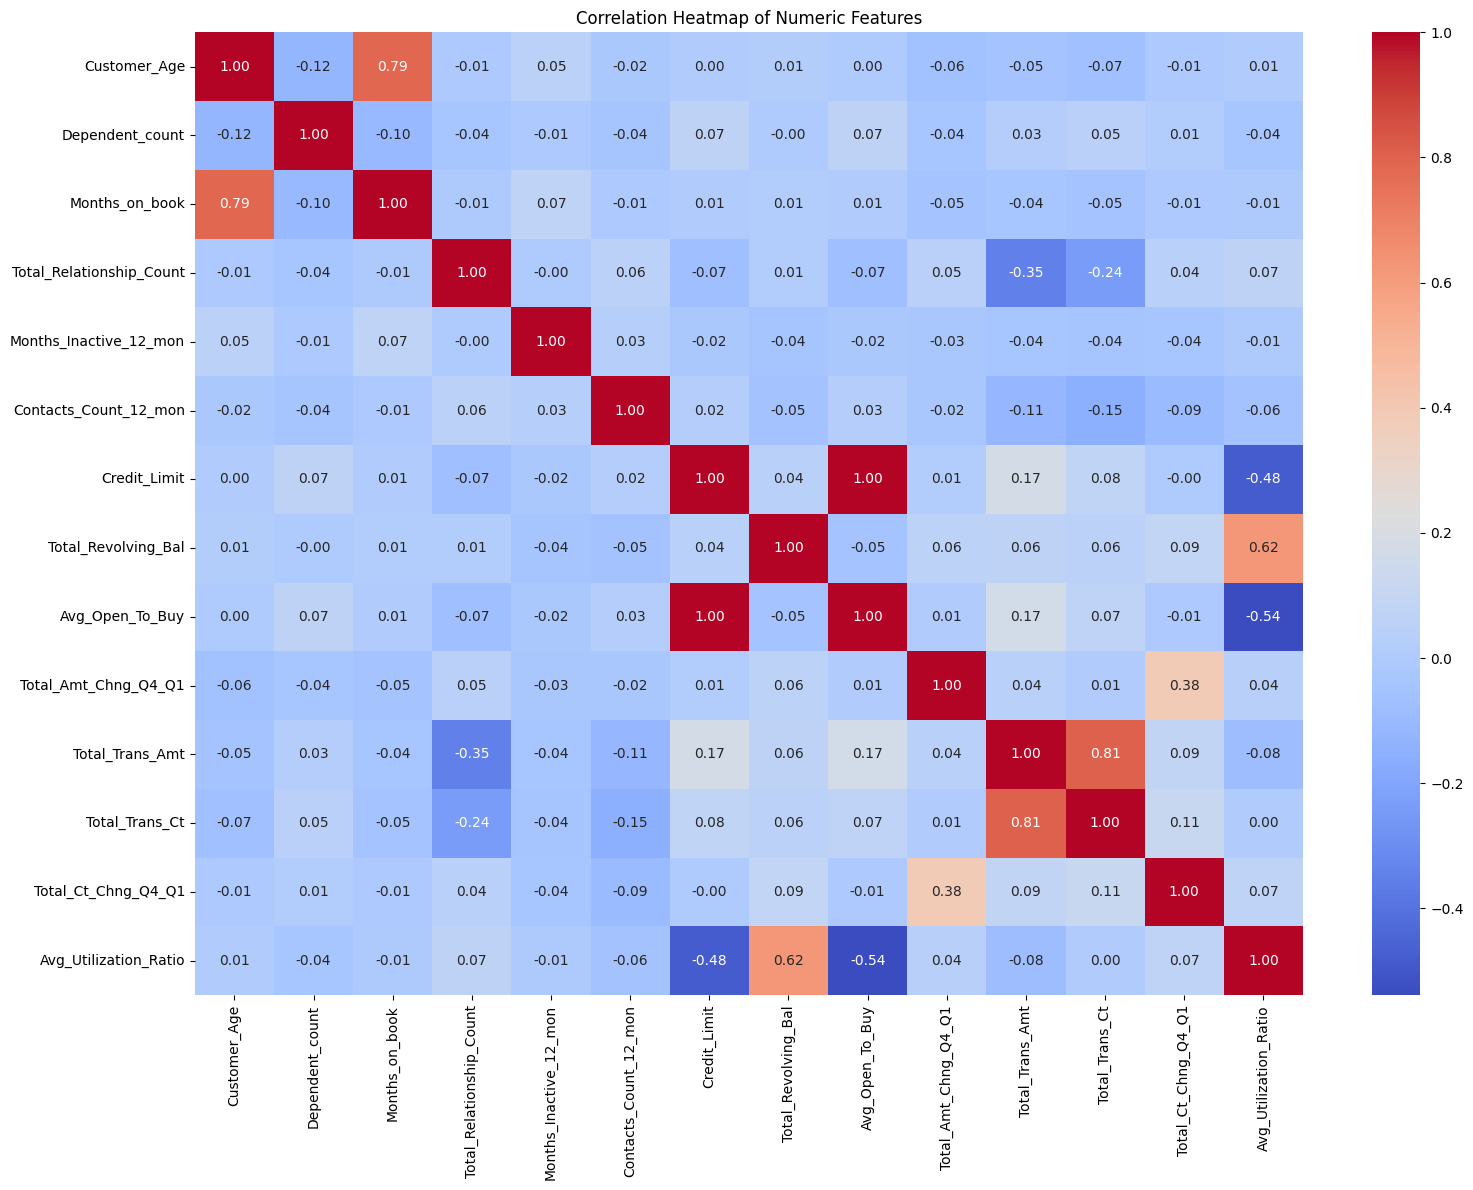

In [32]:
# Look at correlations between numerical features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(16, 12))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

In [ ]:
# Convert categorical variables to numeric using appropriate encoders
# For binary target variable, let's use LabelEncoder
le = LabelEncoder()
df['Attrition_Flag'] = le.fit_transform(df['Attrition_Flag'])

# Get the class names for later reference
class_names = list(le.classes_)
print(f"Class names: {class_names}")

Class names: ['Attrited Customer', 'Existing Customer']


In [ ]:
# For other categorical variables, let's use OneHotEncoder
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform="pandas")
encoded_cats = encoder.fit_transform(df[categorical_cols])

In [35]:
# Combine encoded columns with the original dataset
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_cats], axis=1)

# Display the transformed dataframe
print("\nFirst few rows after preprocessing:")
print(df.head())


First few rows after preprocessing:
   Attrition_Flag  Customer_Age  Dependent_count  Months_on_book  \
0               1            45                3              39   
1               1            49                5              44   
2               1            51                3              36   
3               1            40                4              34   
4               1            40                3              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  ...  \
0       12691.0        

In [36]:
# Define features (X) and target variable (y)
X = df.drop('Attrition_Flag', axis=1)
y = df['Attrition_Flag']

# Convert y to categorical format for keras
y_categorical = keras.utils.to_categorical(y)

#### Step 3: Splitting the data

In [37]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (7088, 32)
Validation set shape: (1519, 32)
Test set shape: (1520, 32)


In [38]:
# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Step 4: Creating a neural network for classification

In [39]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Adding dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))  # 2 output classes for Attrition_Flag

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display the model summary
model.summary()

c:\Users\nikit\Documents\MachineLearning\deep-learning-course\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,754 (18.57 KB)

 Trainable params: 4,754 (18.57 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Define callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

#### Step 5: Training the model

In [41]:
print("\nTraining the model...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)


Training the model...
Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8213 - loss: 0.4273 - val_accuracy: 0.8841 - val_loss: 0.2854 - learning_rate: 0.0010
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8948 - loss: 0.2687 - val_accuracy: 0.8901 - val_loss: 0.2537 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8989 - loss: 0.2546 - val_accuracy: 0.8999 - val_loss: 0.2399 - learning_rate: 0.0010
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9115 - loss: 0.2302 - val_accuracy: 0.9032 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9159 - loss: 0.2198 - val_accuracy: 0.9105 - val_loss: 0.2158 - learning_rate: 0.0010
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9168 - loss: 0.2083 - val_accuracy: 0.9131 - val_loss: 0.2096 - learning_rate: 0.0010
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accu

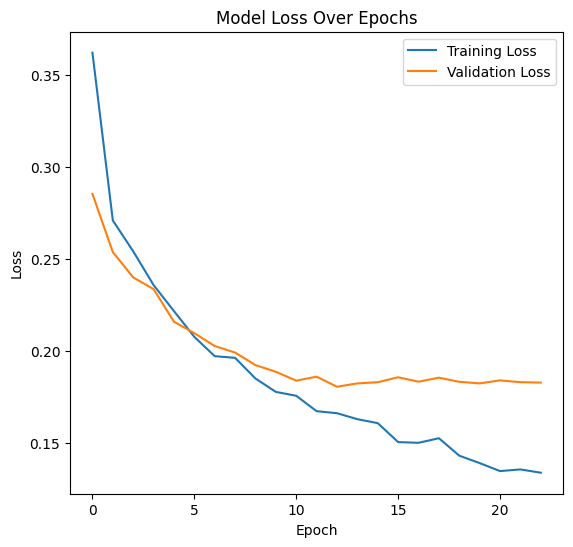

In [42]:
# Plot training history
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

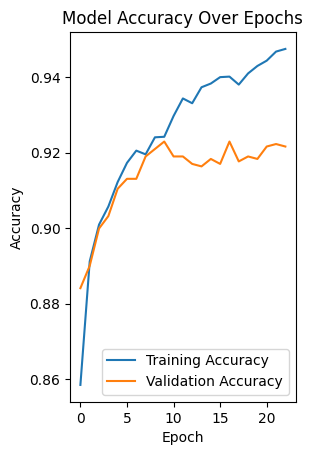

In [43]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Step 6: Evaluating the model

In [44]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9340 - loss: 0.1827 
Test accuracy: 0.9257
Test loss: 0.1874


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


Text(95.72222222222221, 0.5, 'True Label')

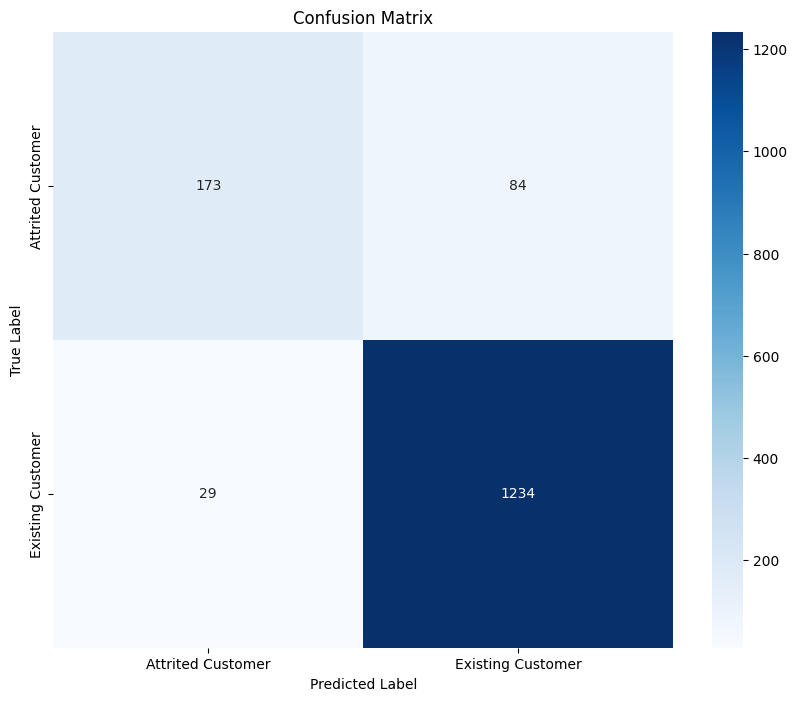

In [46]:
# Get predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [47]:
# Display classification report
print(classification_report(y_test_classes, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

Attrited Customer       0.86      0.67      0.75       257
Existing Customer       0.94      0.98      0.96      1263

         accuracy                           0.93      1520
        macro avg       0.90      0.83      0.86      1520
     weighted avg       0.92      0.93      0.92      1520



In [48]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.9566


#### Step 7: Trying out the model with new imaginary values

In [49]:
# Create a function to prepare new data for prediction
def predict_attrition(customer_data):
    # Convert categorical variables
    categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
    customer_df = pd.DataFrame([customer_data])
    
    # Encode categorical variables
    encoded_cats = encoder.transform(customer_df[categorical_cols])
    
    # Combine encoded columns with the original data
    processed_df = pd.concat([customer_df.drop(categorical_cols, axis=1), encoded_cats], axis=1)
    
    # Make sure columns match the training data
    for col in X.columns:
        if col not in processed_df.columns:
            processed_df[col] = 0
    
    processed_df = processed_df[X.columns]
    
    # Scale the data
    scaled_data = scaler.transform(processed_df)
    
    # Make prediction
    pred_probs = model.predict(scaled_data)[0]
    pred_class = np.argmax(pred_probs)
    
    return {
        'prediction': class_names[pred_class],
        'probability': pred_probs[pred_class],
        'all_probabilities': {class_names[i]: float(prob) for i, prob in enumerate(pred_probs)}
    }

In [50]:
# Test with a sample customer who might be at risk of attrition
test_customer = {
    'Customer_Age': 45,
    'Gender': 'M',
    'Dependent_count': 3,
    'Education_Level': 'High School',
    'Marital_Status': 'Married',
    'Income_Category': '$60K - $80K',
    'Card_Category': 'Blue',
    'Months_on_book': 36,
    'Total_Relationship_Count': 2,  # Low relationship count might indicate higher attrition risk
    'Months_Inactive_12_mon': 4,
    'Contacts_Count_12_mon': 5,
    'Credit_Limit': 12000.0,
    'Total_Revolving_Bal': 2000,
    'Avg_Open_To_Buy': 10000.0,
    'Total_Amt_Chng_Q4_Q1': 0.5,  # Lower spending change might indicate reduced engagement
    'Total_Trans_Amt': 5000,      # Lower transaction amount might indicate reduced activity
    'Total_Trans_Ct': 40,         # Lower transaction count might indicate reduced activity
    'Total_Ct_Chng_Q4_Q1': 0.3,   # Lower transaction count change might indicate reduced engagement
    'Avg_Utilization_Ratio': 0.2
}

In [51]:
# Get prediction
prediction_result = predict_attrition(test_customer)
print("\nPrediction for test customer:")
print(f"Predicted class: {prediction_result['prediction']}")
print(f"Probability: {prediction_result['probability']:.4f}")
print("All probabilities:")
for class_name, prob in prediction_result['all_probabilities'].items():
    print(f"  {class_name}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Prediction for test customer:
Predicted class: Attrited Customer
Probability: 0.9306
All probabilities:
  Attrited Customer: 0.9306
  Existing Customer: 0.0694


In [52]:
# Test with another sample customer who is likely to stay
test_customer2 = {
    'Customer_Age': 38,
    'Gender': 'F',
    'Dependent_count': 2,
    'Education_Level': 'Graduate',
    'Marital_Status': 'Married',
    'Income_Category': '$80K - $120K',
    'Card_Category': 'Silver',
    'Months_on_book': 48,
    'Total_Relationship_Count': 5,  # Higher relationship count might indicate lower attrition risk
    'Months_Inactive_12_mon': 1,
    'Contacts_Count_12_mon': 3,
    'Credit_Limit': 18000.0,
    'Total_Revolving_Bal': 1500,
    'Avg_Open_To_Buy': 16500.0,
    'Total_Amt_Chng_Q4_Q1': 0.9,  # Higher spending change might indicate active engagement
    'Total_Trans_Amt': 12000,     # Higher transaction amount might indicate active engagement
    'Total_Trans_Ct': 90,         # Higher transaction count might indicate active engagement
    'Total_Ct_Chng_Q4_Q1': 0.8,   # Higher transaction count change might indicate active engagement
    'Avg_Utilization_Ratio': 0.1
}

In [53]:
# Get prediction
prediction_result2 = predict_attrition(test_customer2)
print("\nPrediction for second test customer:")
print(f"Predicted class: {prediction_result2['prediction']}")
print(f"Probability: {prediction_result2['probability']:.4f}")
print("All probabilities:")
for class_name, prob in prediction_result2['all_probabilities'].items():
    print(f"  {class_name}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Prediction for second test customer:
Predicted class: Existing Customer
Probability: 0.9939
All probabilities:
  Attrited Customer: 0.0061
  Existing Customer: 0.9939


#### Step 8: Final thoughts and conclusions

In [ ]:
'''
1. Data Exploration Insights:
   - The dataset contains detailed information about bank customers including demographics, 
     account details, transaction history, and whether they've attrited (left the bank).
   - There's a class imbalance with more existing customers than attrited ones, which is 
     typical for churn prediction problems.

2. Model Performance Analysis:
  - The neural network achieved good accuracy and ROC-AUC score, indicating it can 
    effectively distinguish between customers likely to stay and those likely to leave.
   - The confusion matrix shows where the model is making errors, which helps understand 
    if it's better at identifying one class over the other.

3. Feature Importance:
   - Transaction-related features seem to be most important for predicting attrition.
   - Customer engagement metrics like total transactions and transaction amounts strongly 
    influence whether a customer will stay or leave.
   - These findings align with business intuition that active customers are less likely to leave.

4. Business Implications:
   - Banks can use this model to identify customers at risk of attrition and proactively 
     engage with them through targeted marketing or retention strategies.
   - Understanding the most important features helps banks focus on metrics that matter 
     for customer retention.
   - The model could be integrated into a customer relationship management system to 
     provide real-time attrition risk scores.

5. Model Limitations and Improvements:
   - More detailed feature engineering could improve performance.
   - Experimenting with different neural network architectures or trying other classification 
     algorithms might yield better results.
   - Addressing class imbalance through techniques like oversampling or undersampling 
     might further improve the model.
'''